In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

線性回歸就是高中所講的那樣。但這裏我們要推廣到$n$維。對一個$n$維的資料集，其中$y$為目標變量，$mathbf{x}=(x_0,x_1,x_2,...,x_n)$為解釋變量，$x_0=1$。則方程式 $$y=W_0x_0+w_1x_1+...+w_mx_m=\sum_{i=0}^mw_ix_i=w^Tx$$
其中我們定義殘差平方和$$MSE=\frac{1}{N}\sum_{i=1}^N(y^{(i)}-\hat{y}^{(i)})^2=\frac{1}{N}\sum_{i=1}^N(y^{(i)}-\mathbf{w}\cdot\mathbf{x})^2$$
是我們想要最小化的目標函數。
在這一章我們會使用房價資料集

In [6]:
import pandas as pd

df = pd.read_csv('housing.data', header=None,sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


從高中數學我們學到了相關係數的概念，這裡我們任取五個變數，來繪製其散佈圖，並計算其相關係數

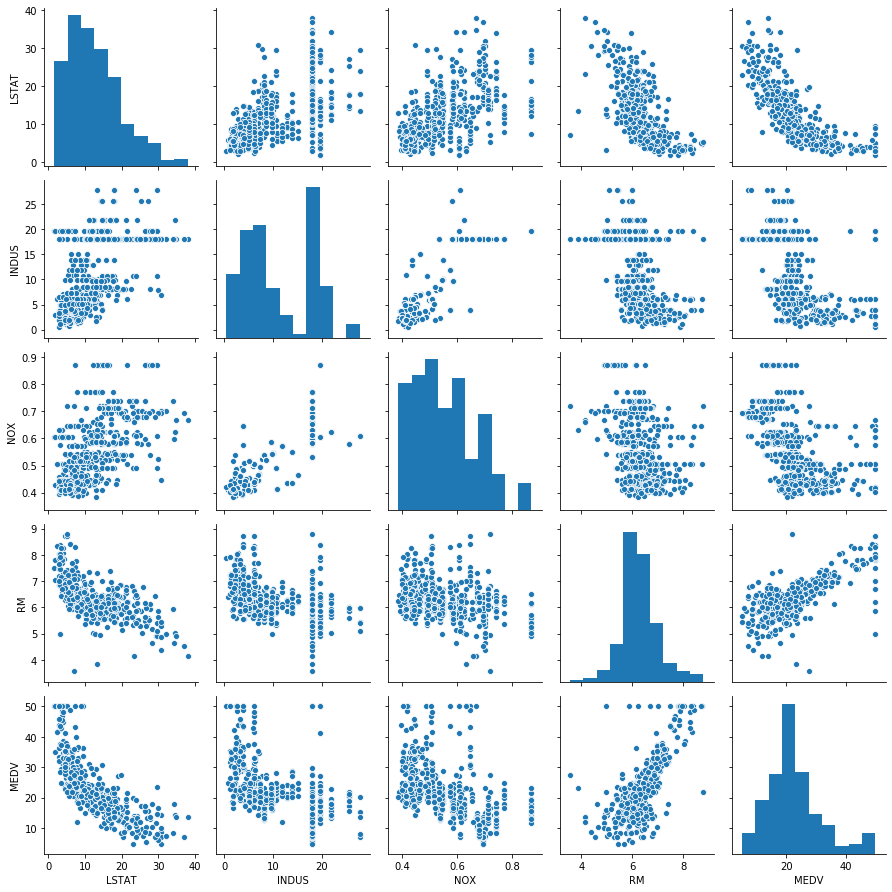

In [8]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] # 選擇這五個來畫

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('images/10_03.png', dpi=300)
plt.show()

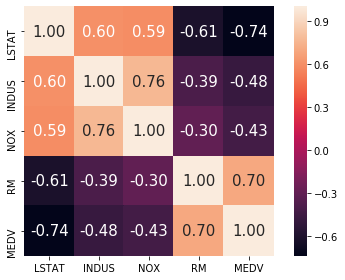

In [9]:
import numpy as np

cm = np.corrcoef(df[cols].values.T) # 計算相關係數
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
# plt.savefig('images/10_04.png', dpi=300)
plt.show()

現在我們要來手刻回歸演算法。我們的cost function與前面的MSE類似，定義如下:
$$J(w)=\frac{1}{2}\sum_{i=1}^N(y^{(i)}-\hat{y}^{(i)})^2$$

In [10]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors) # 利用梯度下降法實作之
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0 # Cost function
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

對RM與MEDV兩個變量來fit，也就是用RM預測MEDV

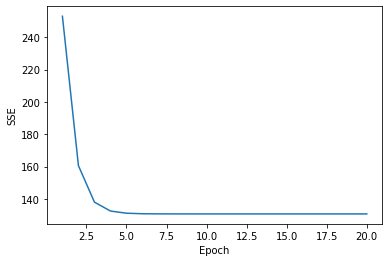

In [11]:
from sklearn.preprocessing import StandardScaler

X = df[['RM']].values # 房間數:解釋變量
y = df['MEDV'].values # 房價: 預測變量
sc_x = StandardScaler() # 標準化後收斂更快
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() # 因為np.newaxis會儲存在二維陣列中，所以用flatten轉回一維

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

# 繪製每次迭代是否收斂
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
#plt.tight_layout()
#plt.savefig('images/10_05.png', dpi=300)
plt.show()

看起來在第五輪後就收斂了。接著繪製回歸曲線

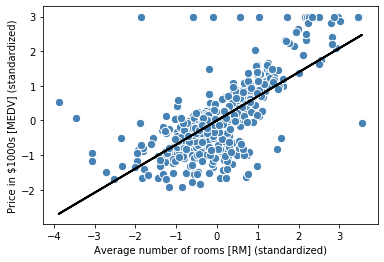

Slope: 0.695
Intercept: -0.000


In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

#plt.savefig('images/10_06.png', dpi=300)
plt.show()

print('Slope: %.3f' % lr.w_[1]) # 顯示回歸曲線斜率
print('Intercept: %.3f' % lr.w_[0]) # 顯示回歸曲線截距(因為我們使用標準化後的數據，所以這邊的截距永遠是0，不用更新)

如果我們想要知道房間數=5的房子大約值多少錢，可以用以下的程式碼:

In [14]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


偉大的scikit learn當然也有已經做好的線性回歸器。我們逐行解說其用法

Slope: 9.102
Intercept: -34.671


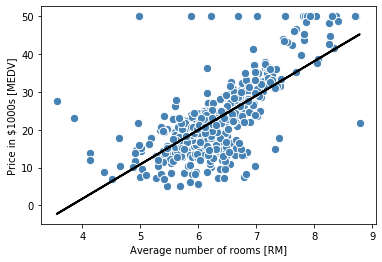

In [15]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0]) # 顯示斜率
print('Intercept: %.3f' % slr.intercept_) # 顯示截距

lin_regplot(X, y, slr) # 繪製散佈圖與回歸直線
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

#plt.savefig('images/10_07.png', dpi=300)
plt.show()